/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/jax/extend/linear_util.py:38: DeprecationWarning: linear_util.wrap_init is missing a DebugInfo object. This behavior is deprecated, use api_util.debug_info() to construct a proper DebugInfo object and propagate it to this function. See https://github.com/jax-ml/jax/issues/26480 for more details.
  debug_info = debug_info or _missing_debug_info("linear_util.wrap_init")
/home/zhangyuhao/miniconda3/envs/brainpy/lib/python3.11/site-packages/brainpy/_src/mixin.py:489: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', Us

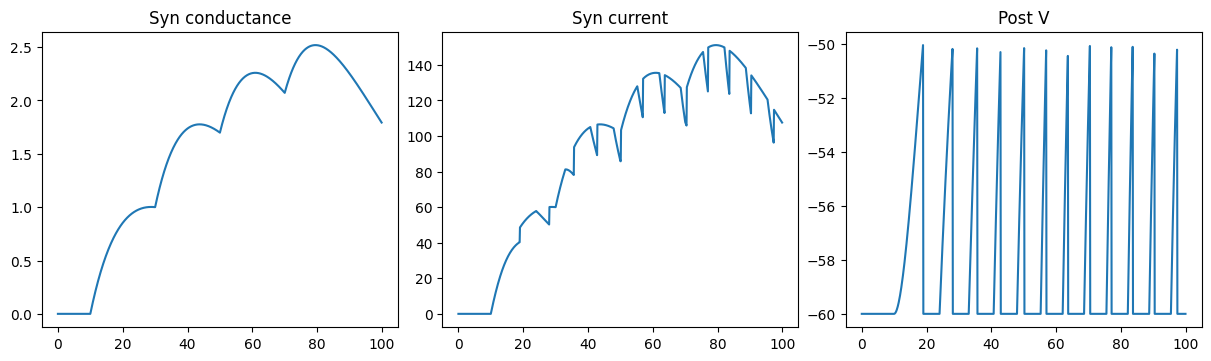

In [8]:
import numpy as np
import brainpy as bp
import brainpy.math as bm

import matplotlib.pyplot as plt

class DualExpSparseCOBA(bp.Projection):
    def __init__(self, pre, post, delay, prob, g_max, tau_decay, tau_rise, E):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
            pre=pre,
            delay=delay,
            syn=bp.dyn.DualExpon.desc(pre.num, tau_decay=tau_decay, tau_rise=tau_rise),
            comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
            out=bp.dyn.COBA(E=E),
            post=post,
        )

class SimpleNet(bp.DynSysGroup):
    def __init__(self, syn_cls, E=0.):
        super().__init__()
        self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
        self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                                  V_initializer=bp.init.Constant(-60.))
        #self.syn = syn_cls(self.pre, self.post, delay=None, prob=1., g_max=1.,
                           #tau_decay=5., tau_rise=1., E=E)
        self.syn = syn_cls(self.pre, self.post, delay=None, prob=1., g_max=1.,
                           tau_decay=15., tau_rise=24., E=E)

    def update(self):
        self.pre()
        self.syn()
        self.post()
        # monitor the following variables
        conductance = self.syn.proj.refs['syn'].g
        current = self.post.sum_inputs(self.post.V)
        return conductance, current, self.post.V


indices = np.arange(1000)  # 100 ms, dt= 0.1 ms
net = SimpleNet(DualExpSparseCOBA, E=0.)
conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
ts = indices * bm.get_dt()
fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
fig.add_subplot(gs[0, 0])
plt.plot(ts, conductances)
plt.title('Syn conductance')
fig.add_subplot(gs[0, 1])
plt.plot(ts, currents)
plt.title('Syn current')
fig.add_subplot(gs[0, 2])
plt.plot(ts, potentials)
plt.title('Post V')
plt.show()